# Tabulated Airway Tree

The following example demonstrates how to work with the structural airway trees' representations in `*_AirwayTreeTable.csv`

We utilize `pandas` for representation of data tables and `matplotlib` for visualization of data.

In [1]:
import os, pandas, matplotlib, numpy
import matplotlib.pyplot as plt

First, we download an example file from the `lapdMouse` data archive using the `lapdMouseUtils` module which is part of the [lapdMousePythonExamples](https://github.com/lapdMouse/lapdMousePythonExamples). We can then load the `.csv` file with `pandas`.

In [2]:
from lapdMouseUtils import DBUtil
DBUtil().downloadFile('m01/m01_AirwayTreeTable.csv')
df = pandas.read_csv('m01/m01_AirwayTreeTable.csv', index_col='label')
df.head(10)

,parent,length,radius,name,centroidX,centroidY,centroidZ,directionX,directionY,directionZ
label,,,,,,,,,,
1,0,3.857900,0.633658,Trachea,15.6271,12.4944,21.1153,-0.063817,0.108764,-0.992017
2,1,5.895780,0.621015,LMB,16.1652,13.0142,16.3458,0.224296,0.105177,-0.968829
3,1,3.423780,0.853296,RMB,14.9932,13.2012,17.6453,-0.298354,0.290323,-0.909229
4,2,1.479900,0.466713,NaN,17.4922,13.0142,13.3994,0.899723,-0.419015,-0.122171
5,2,1.672480,0.803769,LMB,17.0271,13.4337,12.6854,0.239942,0.130883,-0.961924
6,3,1.968140,0.581301,CrRMB,13.6070,13.6572,15.6414,-0.889673,-0.041664,-0.454694
7,3,2.101080,0.898440,RMB,14.3092,13.7803,15.0559,-0.164915,0.078150,-0.983207
8,4,0.650450,0.294075,NaN,18.3677,12.6814,13.5565,0.644939,-0.070105,0.761012
9,4,0.492658,0.387552,NaN,18.3813,12.6631,13.2138,0.907119,-0.166647,-0.386475


The tabulated airway trees represent the tree structure as a set of connected airway segments, where each segment is approximated as a cylinder:
  * **label**: identifier of the airway segment; the root (trachea) has label 1, 
  * **parent**: the parent segment; the root (trachea) as no parent
  * **length**: length of the cylinder
  * **radius**: radius of the cylinder
  * **name**: name of airway branch this segment belongs to, if it belongs to any labeled airway branch, otherwise `NaN`
  * **centroid...**: 3d coordinate of the cylinder center
  * **direction...**: 3d normalized tangent direction of the cylinder pointing in the distal direction of the segment.
  
Labels are assigned such that all children have larger IDs than the parent.

A histogram of the airway radius can be obtained as follows:

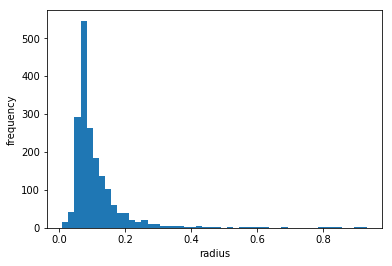

In [3]:
plt.figure()
plt.hist(df['radius'].values,50)
plt.xlabel('radius')
plt.ylabel('frequency');

We define an auxiliary function `visualizeTree`, using lines in a 2d projection of the 3d data to visualize the individual airway segments

In [4]:
def visualizeTree(data, value=None, cmap=None, alpha=1.0):
  if not cmap: cmap=matplotlib.cm.get_cmap('gray')
  plt.figure(figsize=(8,10))
  for index, row in df.iterrows():
    x=[row['centroidX']+0.5*row['length']*row['directionX'],\
      row['centroidX']-0.5*row['length']*row['directionX']]
    z=[row['centroidZ']+0.5*row['length']*row['directionZ'],\
      row['centroidZ']-0.5*row['length']*row['directionZ']]
    c = 'lightgray'
    if value is not None:
      if isinstance(cmap, dict):
        if (index in value) and (value[index] in cmap): c = cmap[value[index]]
      else:
        c = cmap(value[index])
    a = 0.5*alpha if c=='lightgray' else alpha
    plt.plot(x,z,color=c,linewidth=5,alpha=a)
  plt.axis('equal');
  plt.show()

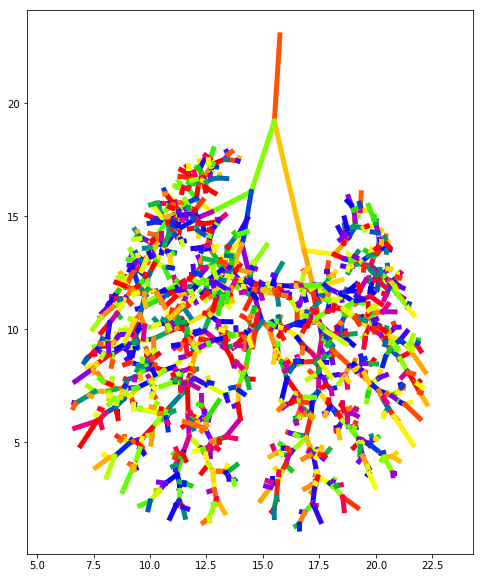

In [5]:
visualizeTree(df,numpy.random.uniform(0,1,df.index.max()+1), matplotlib.cm.get_cmap('prism'))

## Terminal segments
The set of terminal segments, can be found as the set of airway segments that are not parents of any other segment

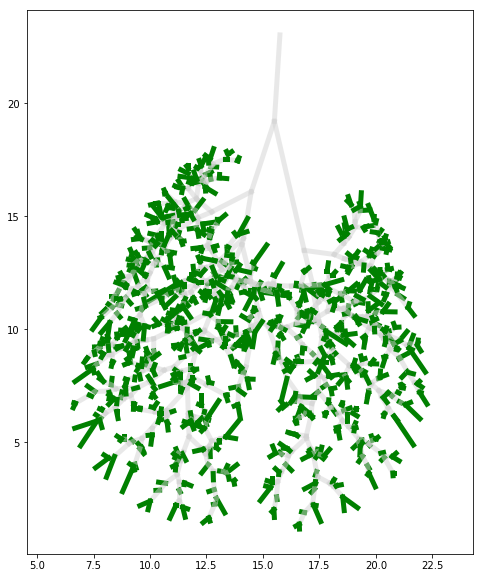

In [6]:
terminalSegments = set(df.index).difference(set(df['parent']))
#print(terminalSegments)
labels = {i:'terminal' for i in df.index if i in terminalSegments}
colors = {'terminal':'green'}
visualizeTree(df, labels, colors)

## Named airway segments
Airway segments belonging to major airway branches are assinged names. Following names are used:
  * **Trachea**
  * **LMB**: Left Bain Bronchus; main airway branch leading into left lung (lobe)
  * **RMB**: Right Bain Bronchus;  main airway branch leading into right lung
  * **CrRMB**: Cranial Right Main Bronchus; main airway branch leading into the cranial lobe of the right lung
  * **MiRMB**: Middle Right Main Bronchus; main airway branch leading into the cranial lobe of the right lung
  * **CaRMB**: Caudal Right Main Bronchus; main airway branch leading into the cranial lobe of the right lung
  * **AcRMB**: Accessory Right Main Bronchus; main airway branch leading into the cranial lobe of the right lung

['Trachea' 'LMB' 'RMB' 'CrRMB' 'MiRMB' 'AcRMB' 'CaRMB']


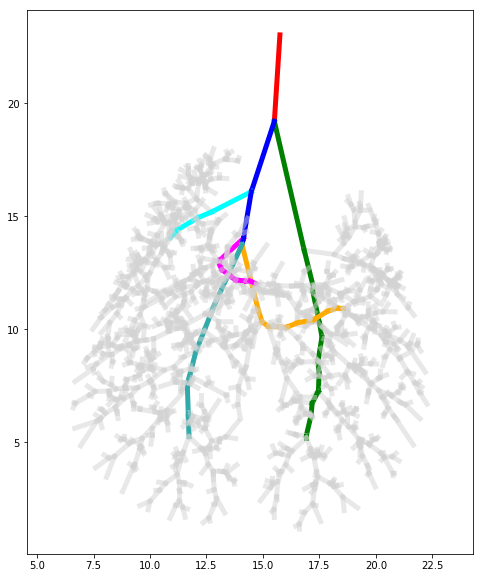

In [7]:
print(df['name'].dropna().unique())
colorForBranchName = {'Trachea':'red','LMB':'green','RMB':'blue',\
  'CrRMB':'cyan','MiRMB':'magenta','AcRMB':'#FFAA00','CaRMB':'#33AAAA'}
visualizeTree(df, df['name'],colorForBranchName)

## Lobe of segment
These labels and the connectivity between segments allows identificiation of the lobe a segment belongs to.

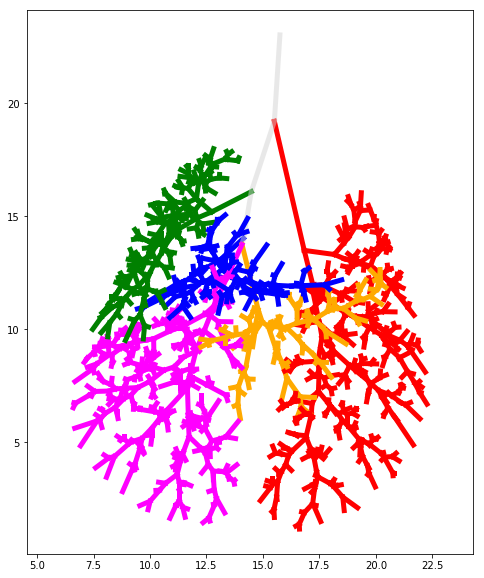

In [8]:
lobeForSegment= df['name'].copy()
lobeForSegment = lobeForSegment\
  .replace('Trachea','none')\
  .replace('LMB','left')\
  .replace('RMB','none')\
  .replace('CrRMB','cranial')\
  .replace('MiRMB','middle')\
  .replace('AcRMB','accessory')\
  .replace('CaRMB','caudal')
for index, value in lobeForSegment.iteritems():
  if pandas.isnull(value):
    parent = df.loc[index,'parent']
    parentLobe = lobeForSegment[parent]
    lobeForSegment[index] = parentLobe

colorForLobeName = {'left':'red','cranial':'green','middle':'blue',\
  'accessory':'#FFAA00','caudal':'magenta', 'none':'lightgray'}
visualizeTree(df, lobeForSegment, colorForLobeName)  

## Finding path to root and children
The example below shows how to find for a given `segmenID`, all segments on the path to the root, and all children

In [9]:
segmentId=673
pathToRoot = []
while (segmentId in df.index):
  pathToRoot.append(segmentId)
  parent = df.loc[segmentId,'parent']
  segmentId = parent
print(pathToRoot)

[673, 535, 403, 283, 175, 93, 47, 23, 11, 5, 2, 1]


In [10]:
segmentId=673
subtree = set([segmentId])
for index, row in df.iterrows():
  if row['parent'] in subtree:
    subtree.add(index)
print('number of segments in subtree: '+str(len(subtree)))

number of segments in subtree: 113


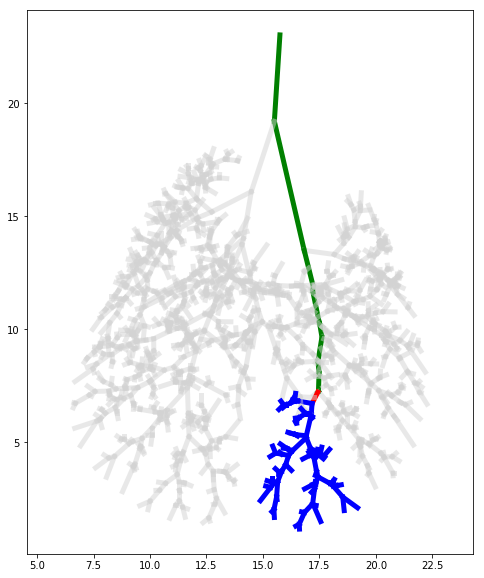

In [11]:
labels = {}
for i in df.index:
  if i==segmentId: labels[i] = 'selected'
  elif i in pathToRoot: labels[i] = 'pathToRoot'
  elif i in subtree: labels[i] = 'subtree'
colors = {'selected':'red', 'pathToRoot':'green','subtree':'blue'}
visualizeTree(df,labels,colors)